In [1]:
import numpy as np
import json
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from google.colab import drive
import random
from joblib import dump
import librosa
from sklearn.preprocessing import StandardScaler
import shutil
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
json_train1 = "/content/drive/MyDrive/Colab Notebooks/espTrainData1.json"
json_train2 = "/content/drive/MyDrive/Colab Notebooks/espTrainData2.json"
json_train3 = "/content/drive/MyDrive/Colab Notebooks/espTrainData3.json"

json_ref1 = "/content/drive/MyDrive/Colab Notebooks/espRefData1.json"
json_ref2 = "/content/drive/MyDrive/Colab Notebooks/espRefData2.json"
json_ref3 = "/content/drive/MyDrive/Colab Notebooks/espRefData3.json"

LEARNING_RATE = 0.00001
BATCH_SIZE = 128

In [16]:
def partirAudio(signal, longitudPartes, hop_length):
    partes = []
    inicio = 0
    fin = longitudPartes
    while(fin<len(signal)):

        partes.append(signal[inicio:fin])

        inicio = fin-hop_length
        fin = fin+longitudPartes-hop_length

    if len(signal)-inicio > longitudPartes/2:
        partes.append(signal[len(signal)-longitudPartes-hop_length:len(signal)-hop_length])

    return partes

def darMFCC(trozo):
    mfccs = librosa.feature.mfcc(y=trozo, n_mfcc=13, hop_length=512, n_fft=2048)

    delta_mfccs = librosa.feature.delta(mfccs) # obtencion primer delta de los mfcc
    delta2_mfccs = librosa.feature.delta(mfccs, order=2) # obtencion segundo delta
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

    return mfccs_features.T

def darZCR(trozo):
    return librosa.feature.zero_crossing_rate(trozo)

def pruebasFinales(persona1, persona2):
  sumaI = 0
  for i in range(len(persona1)):
    sumaPred = 0
    for j in range(3):
        rnd = random.randint(0, len(persona2)-1)
        entrada = [persona1[i], persona2[rnd]]
        entrada = np.asarray(entrada).astype('float32')
        entrada = entrada[np.newaxis, ...]
        entrada = scaler.transform(entrada.reshape(-1, 11*40)).reshape(-1, 2, 40, 11)
        prediction = model.predict(entrada, verbose=False)
        sumaPred+=prediction[0][np.argmax(prediction)]
    sumaPred = sumaPred/3
    sumaI += sumaPred

  media = round(sumaI/len(persona1), 3)*100
  return media

def testAudios():

  listaAudios = ['hombre1-1.wav', 'hombre1-2.wav', 'hombre1-3.wav', 'hombre1-4.wav', 'hombre1-5.wav', 'hombre1-6.wav',  # (0-5)
                 'hombre2-1.wav', 'hombre2-2.wav', 'hombre2-2.wav', # (6-8)
                 'hombre3-1.wav', # (9)
                 'mujer1-1.wav', 'mujer1-2.wav', 'mujer1-3.wav', 'mujer1-4.wav', 'mujer1-5.wav', 'mujer1-6.wav', # (10-15)
                 'mujer2-1.wav', 'mujer2-2.wav', 'mujer2-3.wav', 'mujer2-4.wav', 'mujer2-5.wav', 'mujer2-6.wav', # (16-21)
                 'mujer3-1.wav', 'mujer3-2.wav', # (22-23)
                 'mujer4-1.wav' # (24)
                 ]

  listaParejas = [(0, 4), (0, 7), (2, 8), (1, 9), (0, 13), (2, 22), (5, 24), (4, 3),
                  (6, 8), (6, 5), (6, 23), (9, 13),
                  (12, 14), (15, 10), (13, 21), (14, 22), (18, 12), (19, 7), (16, 21),
                  (22, 23), (22, 12), (22, 7), (22, 5), (24, 10), (24, 17)]

  medioSeg = 11025
  resultados = []

  for pareja in listaParejas:

    audio1, sr1 = librosa.load(listaAudios[pareja[0]])
    audio2, sr2 = librosa.load(listaAudios[pareja[1]])

    trozos1 = partirAudio(audio1, int(medioSeg/2), int(22050/10))
    mfcc1 = []
    trozos2 = partirAudio(audio2, int(medioSeg/2), int(22050/10))
    mfcc2 = []

    for t in trozos1:
        mfcc1.append(np.concatenate((darZCR(t), darMFCC(t).T), axis=0))
    mfcc1 = np.asarray(mfcc1).astype('float32')

    for t in trozos2:
        mfcc2.append(np.concatenate((darZCR(t), darMFCC(t).T), axis=0))
    mfcc2 = np.asarray(mfcc2).astype('float32')

    resultados.append([listaAudios[pareja[0]], listaAudios[pareja[1]], pruebasFinales(mfcc1, mfcc2)])

  aciertos = 0
  for res in resultados:
    if res[0].split("-")[0] == res[1].split("-")[0]:
      if res[2] >= 50:
        aciertos+=1
    else:
      if res[2] < 50:
        aciertos+=1

    print(f'{res[0]} - {res[1]}: {res[2]}%')

  print(f'Se han acertado {aciertos} predicciones --> {(aciertos/len(listaParejas))*100}%')

In [5]:
def cargarDatos(ruta):
    with open(ruta, "r") as fp:
        datos = json.load(fp)

    # Extraer inputs y targets
    X = np.array(datos["MFCCDD"], dtype=float) # se convierte a array de numpy
    y = np.array(datos["ID"])
    z = np.array(datos["ZCR"])

    lista = []

    for muestra in range(len(z)):
      lista.append(np.concatenate((z[muestra], X[muestra].T), axis=0))


    print("Datos cargados")
    return np.asarray(lista, dtype=float), y

In [6]:
def crearSetsDatos(x, y, pctVal, esTest):
  infoClientes = {}
  pos = 0
  # Crea diccionario con forma key: cliente, value: lista [cantidadSegmentosAudio, [posiciones de esos audios en y]]
  # Asi, cuando saque una posicion del diccionario, evito repetirla luego al coger valores aleatorios para los sets de datos
  for cli in y:
    if cli not in infoClientes:
      infoClientes[cli] = [1, [pos]]
    else:
      infoClientes[cli][0] += 1
      infoClientes[cli][1].append(pos)
    pos+=1

  X_temp = []
  y_temp = []
  noPosible = 0

  # Bucle para hacer las parejas de audios de un mismo cliente
  for cli in infoClientes:
    cantidadAudios = int(infoClientes[cli][0]/2)
    if cantidadAudios%2 != 0: # Si no es par se hace par (sino me sobraria uno)
      cantidadAudios+=1

    while cantidadAudios != 0: # Se crean las parejas de audios
      audio1 = infoClientes[cli][1][random.randint(0, len(infoClientes[cli][1])-1)] # Numero aleatorio de la lista de indices de ese cliente
      infoClientes[cli][1].pop(infoClientes[cli][1].index(audio1)) # Se elimina

      audio2 = infoClientes[cli][1][random.randint(0, len(infoClientes[cli][1])-1)] # Mismo proceso que arriba
      infoClientes[cli][1].pop(infoClientes[cli][1].index(audio2))

      X_temp.append([x[audio1][..., np.newaxis], x[audio2][..., np.newaxis]]) # Se guardan en x_temp los valores de los audios de X, ya con los ejes necesarios para la red
      y_temp.append(1) # En y se añade el valor 1, que indica que la persona es la misma

      cantidadAudios-=2 # Se resta 2 porque en cada iteracion se hacen parejas


  # Audios de parejas de clientes diferentes
  while noPosible != 10000:

    if len(infoClientes) > 2: # Si hay minimo 3 clientes todavia se pueden hacer parejas
      primerCliente = random.randint(0, len(infoClientes)-1)

      cont = 0 # Se recorren las claves del diccionario para coger la correspondiente al indice obtenido aleatoriamente
      for key in list(infoClientes.keys()):
        if cont == primerCliente:
          claveCliente1 = key
        cont+=1

      segundoCliente = random.randint(0, len(infoClientes)-1)
      while segundoCliente == primerCliente: # Que no coincidan los clientes
        segundoCliente = random.randint(0, len(infoClientes)-1)

      cont = 0
      for key in list(infoClientes.keys()):
        if cont == segundoCliente:
          claveCliente2 = key
        cont+=1

      audio1 = infoClientes[claveCliente1][1][random.randint(0, len(infoClientes[claveCliente1][1])-1)] # Numero aleatorio de la lista de indices de ese cliente
      infoClientes[claveCliente1][1].pop(infoClientes[claveCliente1][1].index(audio1)) # Se elimina

      audio2 = infoClientes[claveCliente2][1][random.randint(0, len(infoClientes[claveCliente2][1])-1)] # Numero aleatorio de la lista de indices de ese cliente
      infoClientes[claveCliente2][1].pop(infoClientes[claveCliente2][1].index(audio2)) # Se elimina

      X_temp.append([x[audio1][..., np.newaxis], x[audio2][..., np.newaxis]]) # Se guardan en x_temp los valores de los audios de X, ya con los ejes necesarios para la red
      y_temp.append(0) # En y se añade el valor 1, que indica que la persona es la misma

      # Si alguno de los clientes se queda sin archivos de audio, se elimina del diccionario para que no pueda salir mas veces
      if len(infoClientes[claveCliente1][1]) == 0:
        del infoClientes[claveCliente1]
      if len(infoClientes[claveCliente2][1]) == 0:
        del infoClientes[claveCliente2]

    else:
      noPosible+=1

  if esTest:
    return np.asarray(X_temp).astype('float32'), np.array(y_temp, dtype=int)
  else:
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=pctVal, random_state=42)
    return np.asarray(X_train).astype('float32'), np.array(y_train, dtype=int), np.asarray(X_test).astype('float32'), np.array(y_test, dtype=int)

In [7]:
def construirModelo(input_shape, lr):

    # Arquitectura del modelo
    model = Sequential() # 300 300 100 300

    # Conv1
    model.add(Conv2D(600, (3, 3), activation="relu", padding="same", input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(BatchNormalization()) # batch normalization
    model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same")) # max pooling (down samples the output of the convolutional layer)


    # Conv2
    model.add(Conv2D(300, (3, 3), activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))

    # Conv3
    model.add(Conv2D(80, (2, 2), activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(0.001)))

    model.add(BatchNormalization())
    model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))


    # Dense1
    model.add(Flatten())
    model.add(Dense(300, activation="relu"))
    model.add(Dropout(0.2))

    # Dense2
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.3))

    # Softmax classifier (output)
    model.add(Dense(1, activation="sigmoid"))


    # Compilacion del modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    # Overview del modelo
    model.summary()


    return model

In [8]:
xTrain1, yTrain1 = cargarDatos(json_train1)

xTrain2, yTrain2 = cargarDatos(json_train2)

xTrain3, yTrain3 = cargarDatos(json_train3)

print("Cantidad de muestras de entrenamiento: ", len(yTrain1)+len(yTrain2)+len(yTrain3))



Datos cargados
Datos cargados
Datos cargados
Cantidad de muestras de entrenamiento:  324253


In [11]:
X_train, y_train = crearSetsDatos(np.concatenate((xTrain1, xTrain2, xTrain3)), np.concatenate((yTrain1, yTrain2, yTrain3)), 0, True)
print(X_train.shape)

# Necesito liberar memoria
del xTrain1
del xTrain2
del xTrain3
del yTrain1
del yTrain2
del yTrain3

(162125, 2, 40, 11, 1)


In [12]:
# Se crea un objeto StandardScaler para normalizar los datos
scaler = StandardScaler()

# Se aplica el método fit_transform para normalizar los datos de entrenamiento
X_train = scaler.fit_transform(X_train.reshape(-1, 11*40)) # antes los 11 eran 22

# Se reshape los datos para que tengan la forma deseada por la red
X_train = X_train.reshape(-1, 2, 40, 11, 1)

# Guardar el objeto escalador en un archivo
dump(scaler, 'scaler22.joblib')

['scaler22.joblib']

In [13]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
checkpoint = ModelCheckpoint('checkpoint', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
model = construirModelo(input_shape, LEARNING_RATE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 40, 600)        60000     
                                                                 
 batch_normalization (BatchN  (None, 2, 40, 600)       2400      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 20, 600)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 20, 300)        1620300   
                                                                 
 dropout (Dropout)           (None, 1, 20, 300)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 20, 300)       1

In [14]:
# Definir el número de folds y el número de épocas
num_folds = 5
num_epochs = 10

# Crear los objetos KFold para dividir los datos
"""
Another approach is to shuffle the dataset just once prior to splitting the dataset into k folds, and then split, such that the ratio of the observations in each class remains the same in each fold.
Also the test set does not overlap between consecutive iterations. This approach is called Stratified K-Fold CV. This approach is useful for imbalanced datasets. (como tengo mas hombres que mujeres es imbalanced)
"""
skf = StratifiedKFold(n_splits=num_folds, random_state=42, shuffle=True)

# Lista para almacenar las métricas de evaluación en cada fold
evaluations = []
historys = []

In [15]:
# Iterar sobre cada fold
for train_index, val_index in skf.split(X_train, y_train):
    # Dividir los datos en conjuntos de entrenamiento y validación para este fold
    X_trainF, X_valF = X_train[train_index], X_train[val_index]
    y_trainF, y_valF = y_train[train_index], y_train[val_index]

    # Entrenar el modelo en los datos de entrenamiento
    history = model.fit(X_trainF, y_trainF, epochs=num_epochs, batch_size = BATCH_SIZE, validation_data=(X_valF, y_valF), callbacks=[checkpoint, early_stop, reduce_lr])

    # Evaluar el modelo en los datos de validación
    evaluation = model.evaluate(X_valF, y_valF)  # error, acc = model.evaluate

    # Almacenar la evaluación en la lista
    evaluations.append(evaluation)
    historys.append(history)

# Calcular el promedio de las métricas de evaluación
average_evaluation = np.mean(evaluations, axis=0)

# Imprimir las métricas promedio
print("Media de las evaluaciones:")
print("Loss:", average_evaluation[0])
print("Accuracy:", average_evaluation[1])

Epoch 1/10
1014/1014 [==============================] - ETA: 0s - loss: 1.1653 - accuracy: 0.5618
Epoch 1: val_loss improved from inf to 0.95486, saving model to checkpoint


1014/1014 [==============================] - 42s 26ms/step - loss: 1.1653 - accuracy: 0.5618 - val_loss: 0.9549 - val_accuracy: 0.6615 - lr: 1.0000e-05
Epoch 2/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.9086 - accuracy: 0.6625
Epoch 2: val_loss improved from 0.95486 to 0.82606, saving model to checkpoint


1014/1014 [==============================] - 24s 23ms/step - loss: 0.9086 - accuracy: 0.6625 - val_loss: 0.8261 - val_accuracy: 0.7022 - lr: 1.0000e-05
Epoch 3/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.8181 - accuracy: 0.6971
Epoch 3: val_loss improved from 0.82606 to 0.77891, saving model to checkpoint


1014/1014 [==============================] - 25s 24ms/step - loss: 0.8180 - accuracy: 0.6972 - val_loss: 0.7789 - val_accuracy: 0.7107 - lr: 1.0000e-05
Epoch 4/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.7781 - accuracy: 0.7121
Epoch 4: val_loss improved from 0.77891 to 0.75425, saving model to checkpoint


1014/1014 [==============================] - 24s 24ms/step - loss: 0.7781 - accuracy: 0.7121 - val_loss: 0.7542 - val_accuracy: 0.7208 - lr: 1.0000e-05
Epoch 5/10
1014/1014 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.7235
Epoch 5: val_loss improved from 0.75425 to 0.74047, saving model to checkpoint


1014/1014 [==============================] - 24s 24ms/step - loss: 0.7542 - accuracy: 0.7235 - val_loss: 0.7405 - val_accuracy: 0.7267 - lr: 1.0000e-05
Epoch 6/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.7300
Epoch 6: val_loss improved from 0.74047 to 0.73048, saving model to checkpoint


1014/1014 [==============================] - 23s 23ms/step - loss: 0.7392 - accuracy: 0.7300 - val_loss: 0.7305 - val_accuracy: 0.7305 - lr: 1.0000e-05
Epoch 7/10
1014/1014 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.7373
Epoch 7: val_loss improved from 0.73048 to 0.72289, saving model to checkpoint


1014/1014 [==============================] - 24s 24ms/step - loss: 0.7261 - accuracy: 0.7373 - val_loss: 0.7229 - val_accuracy: 0.7318 - lr: 1.0000e-05
Epoch 8/10
1014/1014 [==============================] - ETA: 0s - loss: 0.7153 - accuracy: 0.7417
Epoch 8: val_loss improved from 0.72289 to 0.71446, saving model to checkpoint


1014/1014 [==============================] - 25s 25ms/step - loss: 0.7153 - accuracy: 0.7417 - val_loss: 0.7145 - val_accuracy: 0.7371 - lr: 1.0000e-05
Epoch 9/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.7058 - accuracy: 0.7457
Epoch 9: val_loss improved from 0.71446 to 0.70952, saving model to checkpoint


1014/1014 [==============================] - 24s 23ms/step - loss: 0.7057 - accuracy: 0.7457 - val_loss: 0.7095 - val_accuracy: 0.7391 - lr: 1.0000e-05
Epoch 10/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.6955 - accuracy: 0.7523
Epoch 10: val_loss improved from 0.70952 to 0.70640, saving model to checkpoint


1014/1014 [==============================] - 5s 5ms/step - loss: 0.7064 - accuracy: 0.7409
Epoch 1/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.6957 - accuracy: 0.7501
Epoch 1: val_loss improved from 0.70640 to 0.66623, saving model to checkpoint


1014/1014 [==============================] - 25s 25ms/step - loss: 0.6957 - accuracy: 0.7501 - val_loss: 0.6662 - val_accuracy: 0.7696 - lr: 1.0000e-05
Epoch 2/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.7546
Epoch 2: val_loss improved from 0.66623 to 0.66480, saving model to checkpoint


1014/1014 [==============================] - 23s 23ms/step - loss: 0.6874 - accuracy: 0.7546 - val_loss: 0.6648 - val_accuracy: 0.7693 - lr: 1.0000e-05
Epoch 3/10
1011/1014 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.7604
Epoch 3: val_loss improved from 0.66480 to 0.65909, saving model to checkpoint


1014/1014 [==============================] - 24s 23ms/step - loss: 0.6765 - accuracy: 0.7604 - val_loss: 0.6591 - val_accuracy: 0.7727 - lr: 1.0000e-05
Epoch 4/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.7649
Epoch 4: val_loss improved from 0.65909 to 0.65453, saving model to checkpoint


1014/1014 [==============================] - 23s 23ms/step - loss: 0.6704 - accuracy: 0.7649 - val_loss: 0.6545 - val_accuracy: 0.7728 - lr: 1.0000e-05
Epoch 5/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.7687
Epoch 5: val_loss improved from 0.65453 to 0.65250, saving model to checkpoint


1014/1014 [==============================] - 24s 23ms/step - loss: 0.6609 - accuracy: 0.7687 - val_loss: 0.6525 - val_accuracy: 0.7729 - lr: 1.0000e-05
Epoch 6/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.7727
Epoch 6: val_loss improved from 0.65250 to 0.64870, saving model to checkpoint


1014/1014 [==============================] - 25s 24ms/step - loss: 0.6526 - accuracy: 0.7728 - val_loss: 0.6487 - val_accuracy: 0.7768 - lr: 1.0000e-05
Epoch 7/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.7760
Epoch 7: val_loss improved from 0.64870 to 0.64666, saving model to checkpoint


1014/1014 [==============================] - 23s 23ms/step - loss: 0.6454 - accuracy: 0.7760 - val_loss: 0.6467 - val_accuracy: 0.7746 - lr: 1.0000e-05
Epoch 8/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.6376 - accuracy: 0.7800
Epoch 8: val_loss improved from 0.64666 to 0.64517, saving model to checkpoint


1014/1014 [==============================] - 23s 23ms/step - loss: 0.6377 - accuracy: 0.7800 - val_loss: 0.6452 - val_accuracy: 0.7750 - lr: 1.0000e-05
Epoch 9/10
1011/1014 [============================>.] - ETA: 0s - loss: 0.6305 - accuracy: 0.7838
Epoch 9: val_loss improved from 0.64517 to 0.64047, saving model to checkpoint


1014/1014 [==============================] - 25s 25ms/step - loss: 0.6304 - accuracy: 0.7838 - val_loss: 0.6405 - val_accuracy: 0.7779 - lr: 1.0000e-05
Epoch 10/10
1011/1014 [============================>.] - ETA: 0s - loss: 0.6219 - accuracy: 0.7883
Epoch 10: val_loss did not improve from 0.64047
1014/1014 [==============================] - 5s 5ms/step - loss: 0.6407 - accuracy: 0.7775
Epoch 1/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.6271 - accuracy: 0.7836
Epoch 1: val_loss improved from 0.64047 to 0.59448, saving model to checkpoint


1014/1014 [==============================] - 24s 24ms/step - loss: 0.6271 - accuracy: 0.7836 - val_loss: 0.5945 - val_accuracy: 0.8066 - lr: 1.0000e-05
Epoch 2/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.6199 - accuracy: 0.7887
Epoch 2: val_loss improved from 0.59448 to 0.58936, saving model to checkpoint


1014/1014 [==============================] - 25s 24ms/step - loss: 0.6198 - accuracy: 0.7888 - val_loss: 0.5894 - val_accuracy: 0.8082 - lr: 1.0000e-05
Epoch 3/10
1014/1014 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.7919
Epoch 3: val_loss did not improve from 0.58936
1014/1014 [==============================] - 21s 21ms/step - loss: 0.6122 - accuracy: 0.7919 - val_loss: 0.5919 - val_accuracy: 0.8042 - lr: 1.0000e-05
Epoch 4/10
1014/1014 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.7961
Epoch 4: val_loss improved from 0.58936 to 0.58923, saving model to checkpoint


1014/1014 [==============================] - 25s 25ms/step - loss: 0.6049 - accuracy: 0.7961 - val_loss: 0.5892 - val_accuracy: 0.8046 - lr: 1.0000e-05
Epoch 5/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.7997
Epoch 5: val_loss improved from 0.58923 to 0.58673, saving model to checkpoint


1014/1014 [==============================] - 25s 25ms/step - loss: 0.5971 - accuracy: 0.7997 - val_loss: 0.5867 - val_accuracy: 0.8044 - lr: 1.0000e-05
Epoch 6/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.5895 - accuracy: 0.8026
Epoch 6: val_loss did not improve from 0.58673
1014/1014 [==============================] - 22s 22ms/step - loss: 0.5895 - accuracy: 0.8026 - val_loss: 0.5960 - val_accuracy: 0.7977 - lr: 1.0000e-05
Epoch 7/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.5824 - accuracy: 0.8073
Epoch 7: val_loss improved from 0.58673 to 0.58465, saving model to checkpoint


1014/1014 [==============================] - 23s 23ms/step - loss: 0.5824 - accuracy: 0.8074 - val_loss: 0.5847 - val_accuracy: 0.8034 - lr: 1.0000e-05
Epoch 8/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.5766 - accuracy: 0.8088
Epoch 8: val_loss improved from 0.58465 to 0.58381, saving model to checkpoint


1014/1014 [==============================] - 25s 25ms/step - loss: 0.5765 - accuracy: 0.8088 - val_loss: 0.5838 - val_accuracy: 0.8028 - lr: 1.0000e-05
Epoch 9/10
1011/1014 [============================>.] - ETA: 0s - loss: 0.5696 - accuracy: 0.8126
Epoch 9: val_loss did not improve from 0.58381
1014/1014 [==============================] - 21s 21ms/step - loss: 0.5696 - accuracy: 0.8126 - val_loss: 0.5928 - val_accuracy: 0.7975 - lr: 1.0000e-05
Epoch 10/10
1011/1014 [============================>.] - ETA: 0s - loss: 0.5617 - accuracy: 0.8166
Epoch 10: val_loss did not improve from 0.58381
1014/1014 [==============================] - 5s 5ms/step - loss: 0.5858 - accuracy: 0.8004
Epoch 1/10
1013/1014 [============================>.] - ETA: 0s - loss: 0.5760 - accuracy: 0.8086
Epoch 1: val_loss improved from 0.58381 to 0.50992, saving model to checkpoint


1014/1014 [==============================] - 25s 25ms/step - loss: 0.5761 - accuracy: 0.8086 - val_loss: 0.5099 - val_accuracy: 0.8518 - lr: 1.0000e-05
Epoch 2/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.5673 - accuracy: 0.8126
Epoch 2: val_loss did not improve from 0.50992
1014/1014 [==============================] - 21s 21ms/step - loss: 0.5673 - accuracy: 0.8125 - val_loss: 0.5131 - val_accuracy: 0.8483 - lr: 1.0000e-05
Epoch 3/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.5597 - accuracy: 0.8163
Epoch 3: val_loss did not improve from 0.50992
1014/1014 [==============================] - 21s 21ms/step - loss: 0.5596 - accuracy: 0.8163 - val_loss: 0.5147 - val_accuracy: 0.8445 - lr: 1.0000e-05
Epoch 4/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.8181
Epoch 4: val_loss did not improve from 0.50992
1014/1014 [==============================] - 5s 4ms/step - loss: 0.5126 - accuracy: 0.8435
Epoch 1/10
1012/10

1014/1014 [==============================] - 26s 25ms/step - loss: 0.5534 - accuracy: 0.8179 - val_loss: 0.4804 - val_accuracy: 0.8648 - lr: 1.0000e-05
Epoch 2/10
1011/1014 [============================>.] - ETA: 0s - loss: 0.5442 - accuracy: 0.8230
Epoch 2: val_loss did not improve from 0.48038
1014/1014 [==============================] - 26s 25ms/step - loss: 0.5441 - accuracy: 0.8231 - val_loss: 0.4838 - val_accuracy: 0.8609 - lr: 1.0000e-05
Epoch 3/10
1012/1014 [============================>.] - ETA: 0s - loss: 0.5380 - accuracy: 0.8262
Epoch 3: val_loss did not improve from 0.48038
1014/1014 [==============================] - 21s 21ms/step - loss: 0.5380 - accuracy: 0.8262 - val_loss: 0.4875 - val_accuracy: 0.8580 - lr: 1.0000e-05
Epoch 4/10
1014/1014 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.8290
Epoch 4: val_loss did not improve from 0.48038
1014/1014 [==============================] - 4s 4ms/step - loss: 0.4991 - accuracy: 0.8464
Media de las evalu

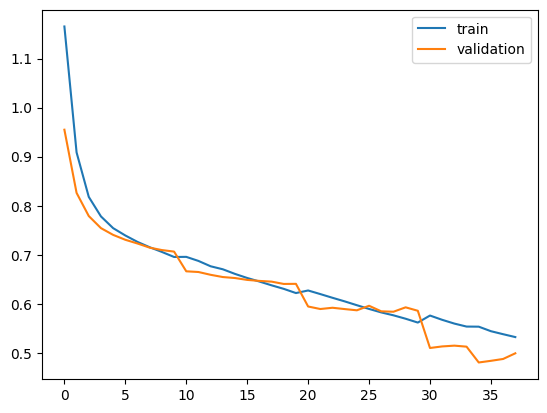

In [17]:
pyplot.plot(historys[0].history['loss'] + historys[1].history['loss'] + historys[2].history['loss'] + historys[3].history['loss'] + historys[4].history['loss'], label='train')
pyplot.plot(historys[0].history['val_loss'] + historys[1].history['val_loss'] + historys[2].history['val_loss'] + historys[3].history['val_loss'] + historys[4].history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [19]:
testAudios()

<ipython-input-16-235d2b4e051f>:70: UserWarning: PySoundFile failed. Trying audioread instead.
  audio1, sr1 = librosa.load(listaAudios[pareja[0]])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-16-235d2b4e051f>:71: UserWarning: PySoundFile failed. Trying audioread instead.
  audio2, sr2 = librosa.load(listaAudios[pareja[1]])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-16-235d2b4e051f>:70: UserWarning: PySoundFile failed. Trying audioread instead.
  audio1, sr1 = librosa.load(listaAudios[pareja[0]])
/usr/local/lib/pyt

hombre1-1.wav - hombre1-5.wav: 55.800000000000004%
hombre1-1.wav - hombre2-2.wav: 24.5%
hombre1-3.wav - hombre2-2.wav: 17.8%
hombre1-2.wav - hombre3-1.wav: 13.600000000000001%
hombre1-1.wav - mujer1-4.wav: 30.099999999999998%
hombre1-3.wav - mujer3-1.wav: 22.7%
hombre1-6.wav - mujer4-1.wav: 5.5%
hombre1-5.wav - hombre1-4.wav: 61.5%
hombre2-1.wav - hombre2-2.wav: 76.6%
hombre2-1.wav - hombre1-6.wav: 20.5%
hombre2-1.wav - mujer3-2.wav: 41.0%
hombre3-1.wav - mujer1-4.wav: 11.200000000000001%
mujer1-3.wav - mujer1-5.wav: 68.60000000000001%
mujer1-6.wav - mujer1-1.wav: 65.9%
mujer1-4.wav - mujer2-6.wav: 58.699999999999996%
mujer1-5.wav - mujer3-1.wav: 11.1%
mujer2-3.wav - mujer1-3.wav: 57.099999999999994%
mujer2-4.wav - hombre2-2.wav: 12.7%
mujer2-1.wav - mujer2-6.wav: 57.099999999999994%
mujer3-1.wav - mujer3-2.wav: 66.2%
mujer3-1.wav - mujer1-3.wav: 15.0%
mujer3-1.wav - hombre2-2.wav: 59.5%
mujer3-1.wav - hombre1-6.wav: 14.899999999999999%
mujer4-1.wav - mujer1-1.wav: 6.5%
mujer4-1.wav - 

In [ ]:
model.save("modelo22.h5")

shutil.copy("modelo22.h5","/content/drive/MyDrive/Colab Notebooks/")

In [20]:
xRef1, yRef1 = cargarDatos(json_ref1)

xRef2, yRef2 = cargarDatos(json_ref2)

xRef3, yRef3 = cargarDatos(json_ref3)

print("Cantidad de muestras de entrenamiento: ", len(yRef1)+len(yRef2)+len(yRef3))

Datos cargados
Datos cargados
Datos cargados
Cantidad de muestras de entrenamiento:  86168


In [31]:
X_ref, y_ref, X_val, y_val = crearSetsDatos(np.concatenate((xRef1, xRef2, xRef3)), np.concatenate((yRef1, yRef2, yRef3)), 0.1, False)
X_ref.shape

(38768, 2, 40, 11, 1)

In [32]:
# Se aplica el método transform para normalizar los datos de validación y test
X_ref = scaler.transform(X_ref.reshape(-1, 11*40))
X_val = scaler.transform(X_val.reshape(-1, 11*40))

# Se reshape los datos para que tengan la forma deseada por la red
X_ref = X_ref.reshape(-1, 2, 40, 11, 1)
X_val = X_val.reshape(-1, 2, 40, 11, 1)

In [34]:
history = model.fit(X_ref, y_ref, epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stop, reduce_lr])

Epoch 1/15
606/606 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.7591
Epoch 1: val_loss did not improve from 0.48038
606/606 [==============================] - 9s 14ms/step - loss: 0.6529 - accuracy: 0.7591 - val_loss: 0.6209 - val_accuracy: 0.7649 - lr: 1.0000e-05
Epoch 2/15
605/606 [============================>.] - ETA: 0s - loss: 0.6222 - accuracy: 0.7702
Epoch 2: val_loss did not improve from 0.48038
606/606 [==============================] - 8s 13ms/step - loss: 0.6221 - accuracy: 0.7703 - val_loss: 0.6227 - val_accuracy: 0.7632 - lr: 1.0000e-05
Epoch 3/15
604/606 [============================>.] - ETA: 0s - loss: 0.6085 - accuracy: 0.7804
Epoch 3: val_loss did not improve from 0.48038
606/606 [==============================] - 8s 13ms/step - loss: 0.6084 - accuracy: 0.7805 - val_loss: 0.6127 - val_accuracy: 0.7734 - lr: 1.0000e-05
Epoch 4/15
604/606 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.7868
Epoch 4: val_loss did not im

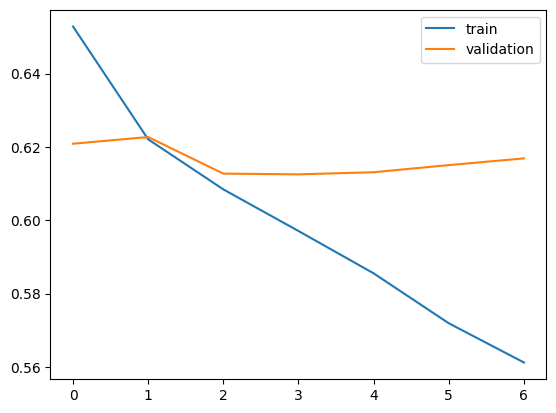

In [35]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [37]:
testAudios()

<ipython-input-16-235d2b4e051f>:70: UserWarning: PySoundFile failed. Trying audioread instead.
  audio1, sr1 = librosa.load(listaAudios[pareja[0]])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-16-235d2b4e051f>:71: UserWarning: PySoundFile failed. Trying audioread instead.
  audio2, sr2 = librosa.load(listaAudios[pareja[1]])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-16-235d2b4e051f>:70: UserWarning: PySoundFile failed. Trying audioread instead.
  audio1, sr1 = librosa.load(listaAudios[pareja[0]])
/usr/local/lib/pyt

hombre1-1.wav - hombre1-5.wav: 65.4%
hombre1-1.wav - hombre2-2.wav: 29.099999999999998%
hombre1-3.wav - hombre2-2.wav: 29.2%
hombre1-2.wav - hombre3-1.wav: 22.6%
hombre1-1.wav - mujer1-4.wav: 36.5%
hombre1-3.wav - mujer3-1.wav: 26.1%
hombre1-6.wav - mujer4-1.wav: 17.599999999999998%
hombre1-5.wav - hombre1-4.wav: 71.7%
hombre2-1.wav - hombre2-2.wav: 79.4%
hombre2-1.wav - hombre1-6.wav: 28.1%
hombre2-1.wav - mujer3-2.wav: 47.4%
hombre3-1.wav - mujer1-4.wav: 15.8%
mujer1-3.wav - mujer1-5.wav: 79.4%
mujer1-6.wav - mujer1-1.wav: 73.6%
mujer1-4.wav - mujer2-6.wav: 66.8%
mujer1-5.wav - mujer3-1.wav: 12.9%
mujer2-3.wav - mujer1-3.wav: 70.6%
mujer2-4.wav - hombre2-2.wav: 21.2%
mujer2-1.wav - mujer2-6.wav: 71.1%
mujer3-1.wav - mujer3-2.wav: 66.3%
mujer3-1.wav - mujer1-3.wav: 17.7%
mujer3-1.wav - hombre2-2.wav: 60.9%
mujer3-1.wav - hombre1-6.wav: 23.9%
mujer4-1.wav - mujer1-1.wav: 14.899999999999999%
mujer4-1.wav - mujer2-2.wav: 30.099999999999998%
Se han acertado 22 predicciones --> 88.0%


In [36]:
model.save("modelo22-1.h5")

shutil.copy("modelo22-1.h5","/content/drive/MyDrive/Colab Notebooks/")

'/content/drive/MyDrive/Colab Notebooks/modelo22-1.h5'